# Problem 6 - Phase Identification(2)

## Agenda
- Problem Description
- Problem Implementation
- Wrap-Up

## Problem Description
- <b>Consider a grid for which we do not have sufficient metering data $z_{meter}$ and estimate the state vector $x$ that fully characterizes the condition in which the grid is operated,given the grid static information of its structure and corresponding component models, and the standard measurement values of all grid connected loads.
    
    -<b>Let us use the four-bus radial feeder system of the previous example and assume we have access to real-time voltage measurements on bus k (as before). Assuming pseudo-measurements on per-phase load currents are available, we want to estimate the remaining feeder bus voltages.

Considered network
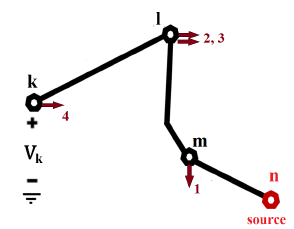

<b>Import Python Libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Parameters

In [19]:
cosPhi=0.95
#time=48
m=12
netFactor=0.25
#noiseFactor=0.005

<b>Initial data

In [20]:
#Consumption dataset
s=  [[0.0450,    0.0150,    0.0470,    0.0330],
     [0.0250,    0.0150,    0.2480,    0.0330],
     [0.0970,    0.0250,    0.3940,    0.0330],
     [0.0700,    0.0490,    0.0200,    0.4850],
     [0.1250,    0.0460,    0.0160,    0.1430],
     [0.2900,    0.0270,    0.0160,    0.0470],
     [0.2590,    0.0150,    0.0170,    0.0200],
     [0.2590,    0.0160,    0.0280,    0.0160],
     [0.4420,    0.0160,    0.0500,    0.0170],
     [0.2010,    0.0230,    0.0460,    0.0160],
     [0.2060,    0.0490,    0.0220,    0.0240],
     [0.1300,    0.0470,    0.0160,    0.0490],
     [0.0460,    0.0260,    0.0170,    0.0480]]
s = np.array(s)

#topology
topo=[[1, 2],[2,3],[3,4]]
nBUS=np.max(topo)

#Impedance
z=np.multiply([complex(0.1,0.05),complex(0.15,0.07),complex(0.2,0.1)],netFactor)

vr=1 #Reference voltage
el=1
ni=20 #Iterations for the Power Flow




<b>Power Flow Function

In [21]:
def pf3ph(t,z,si,vr,el,ni,al):
    #Matrices creation
    t=np.array(t)
    p=t[:,0]
    f=t[:,1]
    w=len(p)+1
    vp=np.zeros((nBUS-1,w), dtype=complex)
    vn=np.zeros((nBUS-1,w), dtype=complex)
    vp[0,0:w]=vr
    
    for h in range (2,nBUS):
        vp[h-1,:]=vp[h-2,:]*al  #Create a three phase system of voltages
                                #Voltages will be the same in all BUS

    va=vp-vn                                                      #Auxiliar voltage
    ia=np.conj(np.divide(np.multiply(si,np.abs(va)**el),va))      #Auxiliar current 
    
    for it in range(ni):                                          #Iterations of Power Flow
        va=vp-vn
        ip=np.conj(np.divide(np.multiply(si,np.abs(va)**el),va))  #Phase current 
        inn=-np.sum(ip,0)                                         #Neutral current 

        for k in range(w-1,0,-1):                                 #Backward Cycle
            n=f[k-1]
            m=p[k-1]
            ip[:,m-1]=ip[:,m-1]+ip[:,n-1]                         #Phase Current
            inn=-np.sum(ip,0)                                     #Neutral Current

        eps= np.linalg.norm(np.max(np.abs(ia-ip),0))              #Error, comparing the new currents and the old ones (previous iteration)

        if eps>1e-4:
            ia=ip
            mvp=0
            mvn=0
            eps=np.inf
        else:                       #If the error is lower than the limit, we can return the results 
            mvp=(vp-vn)             #Phase Voltages to return
            mvn=vn[0,:]             #Neutral Voltage to return
#            return mvp, mvn, eps, ip, inn;
            return mvp, ip;
        for k in range (w-1):                     #Forward Cycle
            n=f[k]                                
            m=p[k]
            vn[:,n-1]=vn[:,m-1]-z[k]*inn[n-1]     #Neutral Voltage 
            vp[:,n-1]=vp[:,m-1]-z[k]*ip[:,n-1]    #Phase Voltage
        ia=ip             #Save the current of previous iteration



<b>Compute the values of voltages in function of currents

In [22]:
al=np.exp(np.multiply(np.multiply(complex(0,-1),2/3),np.pi)) #Phase Angle
sp=np.mean(s[0:m,:], axis=0) #Average power in each phase (i0)

si=[[0, 0, sp[2], 0],[0, 0, sp[1], 0],[0, sp[0],  0, sp[3]]] #Power in each bus and in each phase

mvp, ip=pf3ph(topo,z,si,vr,el,ni,al)  #Compute the power flow

zv=mvp[:,3]    #Voltage Measurement in Node 4 

print('The values of the currents are:\n',ip)

The values of the currents are:
 [[ 0.07666399-0.00064047j  0.07666399-0.00064047j  0.07666399-0.00064047j
   0.        -0.j        ]
 [-0.0141556 -0.02483195j -0.0141556 -0.02483195j -0.0141556 -0.02483195j
  -0.        +0.j        ]
 [-0.12640751+0.22194277j -0.12640751+0.22194277j -0.03759005+0.06643618j
  -0.03759005+0.06643618j]]


<b>State Estimation
   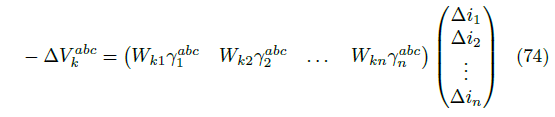
    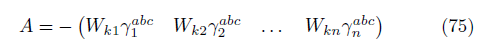
    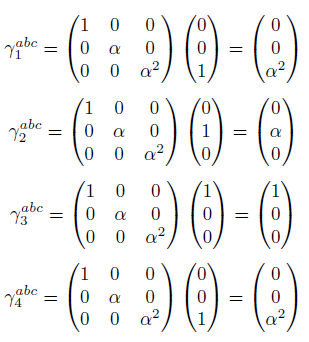
    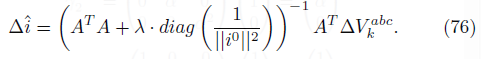

In [26]:
#Matrices Creation
it=np.zeros((3,m))
ie=np.zeros((3,m))
A=np.zeros((3,4), dtype=complex)
dx=np.zeros((4,m), dtype=complex)

W=[[2,1,1],
   [1,2,1],
   [1,1,2]]
W = np.array(W)

ds=s[0:m,:]-sp              #Difference from the average
scale=1e-9*np.abs(1/sp)**2  #Measurements Accuracy

for i in range(m):
    # Power in each instant
    # Load Flow
    # Voltage in Node 4
    # Voltage Variation
    # Current (Complex)
    # Current (Absolute)
    # Compute matrix A

    A[0, 0:2] = -np.conj(ip[0, i]) * (1 - (np.abs(ip[0, i])**2) / (np.abs(ip[0, i])**2 + np.abs(ip[1, i])**2))
    A[1, 1:3] = -np.conj(ip[1, i]) * (1 - (np.abs(ip[1, i])**2) / (np.abs(ip[1, i])**2 + np.abs(ip[2, i])**2))
    A[2, 2:4] = -np.conj(ip[2, i]) * (1 - (np.abs(ip[2, i])**2) / (np.abs(ip[2, i])**2 + np.abs(ip[0, i])**2))

    dv = ds[i, :]

    # Determine the variation of current i
    Atrans = np.transpose(A)
    di = np.dot(np.dot(-Atrans, np.linalg.inv(np.dot(Atrans, A))), dv.reshape(-1, 1)).flatten()  # Min-norm sol.

    # Save the result in a vector
    dx[:, i] = di

    # Verification considering the obtained values
    it[:, i] = np.abs(ip[:, i]) + np.abs(di)
    ie[:, i] = np.abs(ip[:, i]) * np.exp(1j * np.angle(ip[:, i] + di)) - ip[:, i]


print ('i0\n',sp,'\n')

print ('A\n',A,'\n')

print ('di\n',dx,'\n')

ValueError: shapes (4,3) and (4,4) not aligned: 3 (dim 1) != 4 (dim 0)

<b>Graphics

In [ ]:
yy1 = sp
yy2 = sp+np.transpose(dx)
yy3 = ds
yy4 = ds-np.transpose(dx)


#Graph 1
for i in range (1,m):
    plt.plot(yy1, yy2[i,:], 'C0o')

plt.xlabel("Pseudo-measurement [pu]")
plt.ylabel("Estimation [pu]")
plt.show()

#Graph 2
for i in range (1,m):
    plt.plot(yy3[i,:], yy4[i,:], 'C0o')

plt.xlabel("Pseudo-measurement error [pu]")
plt.ylabel("Estimation error [pu]")
plt.show()

NameError: name 'sp' is not defined